Změny oproti předešlé verzi
- hezčí vložení indexu do df při výpočtech nových hodnot
- řazení výsečí grafů podle listů
- použití f' stringu při pojmenovávání grafů
- sloupec 'geo_time' přejmenován na 'geo'

Ve výpočtech nových hodnot oprav přidávání indexů

Import modulů

In [445]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import eurostat

## Zvol ROK a STÁT

In [446]:
YEAR = 2018 
STATE = 'SK'  

Popisky



In [447]:
label_dict_1 = {'CRF2':'Průmyslové procesy (výroba cementu, oceli,...)', 
              'CRF1A3_CRF1D1A':'Doprava (včetně letecké)',
              'CRF1A2':'Spalování v průmyslu', 
              'CRF1A1':'Energetika',
              'CRF1A4':'Spalování v domácnostech, institucích a zemědělství',
              'CRF3':'Zemědělství',
              'CRF5':'Odpadové hospodářství',
              'TOTX4_MEMONIA':'jiné'}

label_dict_2 = {'CRF2C':'Zpracování oceli a kovů',
               'CRF2A':'Minerální produkce (cement, vápno, ...)',
              'CRF2B':'Chemický průmysl',
              'CRF2_rozdil':'Další průmyslové procesy',
              'CRF1A3B1':'Osobní automobilová doprava',
              'CRF1A3B2_CRF1A3B3':'Nákladní a autobusová doprava',
              'CRF1D1A_CRF1A3A':'Letecká doprava',
              'CRF1A3_rozdil':'Jiná doprava',
              'CRF1A2A_CRF1A2B':'Spalování při zpracování oceli a kovů',
              'CRF1A2_rozdil':'Další spalování v průmyslu',
              'CRF1A1C_CRF1A1B':'Rafinace, výroba a úprava paliv',
              'CRF1A1_rozdil_X':'Teplárny a elektrárny',
              'CRF1A4':'Spalování v domácnostech, institucích a zemědělství',
              'CRF3':'Zemědělství',
              'CRF5':'Odpadové hospodářství',
              'TOTX4_MEMONIA':'jiné'}

inner_sort_order = ['CRF2',
                   'CRF1A3_CRF1D1A',
                   'CRF1A2',
                   'CRF1A1',
                   'CRF1A4',
                   'CRF3',
                   'CRF5',
                   'TOTX4_MEMONIA']

outer_sort_order = ['CRF2C',
                   'CRF2A',
                   'CRF2B',
                   'CRF2_rozdil',
                   'CRF1A3B1',
                   'CRF1A3B2_CRF1A3B3',
                   'CRF1D1A_CRF1A3A',
                   'CRF1A3_rozdil',
                   'CRF1A2A_CRF1A2B',
                   'CRF1A2_rozdil',
                   'CRF1A1C_CRF1A1B',
                   'CRF1A1_rozdil_X',
                   'CRF1A4',
                   'CRF3',
                   'CRF5',
                   'TOTX4_MEMONIA']

Stáhni dataframe "env_air_gge"

In [448]:
df = eurostat.get_data_df('env_air_gge')

In [449]:
df.head(2) 

,unit,airpol,src_crf,geo\time,2020,2019,2018,2017,2016,2015,...,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985
0,MIO_T,CH4,CRF1,AT,0.02177,0.02223,0.02289,0.02578,0.02442,0.02428,...,0.03347,0.04038,0.04278,0.04369,0.04858,NaN,NaN,NaN,NaN,NaN
1,MIO_T,CH4,CRF1,BE,0.04085,0.04232,0.04160,0.04206,0.04275,0.04287,...,0.04837,0.05451,0.05340,0.05934,0.06406,NaN,NaN,NaN,NaN,NaN


Přejmenuj sloupec ať se s tím dá pracovat

In [450]:
# Pandas query() does not allow backslash in column names so "rename column" is needed. 
df = df.rename(columns={'geo\\time': 'geo'}) 

Dataframe pro Slovensko v milionech tun GHG CO2 ekvivalentu

In [451]:
df2 = df.query("airpol == 'GHG' and geo == @STATE and unit == 'MIO_T'") 
df2.head(2)

,unit,airpol,src_crf,geo,2020,2019,2018,2017,2016,2015,...,1994,1993,1992,1991,1990,1989,1988,1987,1986,1985
13330,MIO_T,GHG,CRF1,SK,24.60852,26.84846,28.29565,28.44574,27.50871,27.34669,...,39.18166,41.64202,45.61166,49.84740,56.27949,NaN,NaN,NaN,NaN,NaN
13366,MIO_T,GHG,CRF1A,SK,24.18342,26.36847,27.83462,27.91228,26.94201,26.77401,...,36.93856,39.37876,43.26013,47.46876,53.86689,NaN,NaN,NaN,NaN,NaN


Data frame pro kod odvětví (src_crf) a rok.

In [452]:
df3 = df2[["src_crf", YEAR]] 

Vybírám jen určitá odvětví

In [453]:
df4 = df3.query("src_crf in ('CRF2', 'CRF1A2', 'CRF1A1','CRF1A4','CRF5','CRF3','CRF1A3','CRF1D1A' )") 

Nastav sloupec "src_crf" jako index

In [454]:
df4 = df4.set_index('src_crf') 

## Výpočty nových hodnot

Sečti dvě odvětví (CRF1A3 a CRF1D1A) a přidej je do tabulky

In [455]:
A = df4.loc['CRF1A3', YEAR] + df4.loc['CRF1D1A', YEAR] 
A_df = pd.DataFrame({YEAR:[A]},  index = ['CRF1A3_CRF1D1A']) # vytvoř nový df se sloupcem "YEAR", příslušným indexem a hodnotou vypoč. jako "A"
df4 = df4.append(A_df) # přilep nový dataframe ke stávajícímu 

Vyhoď jednotlivý řádky pro CRF1A3 a CRF1D1A ať to není zastoupený 2x

In [456]:
df4 = df4.drop(index = 'CRF1A3') 
df4 = df4.drop(index = 'CRF1D1A')

### Dopočítej rozdíl do celku

Získej hodnotu pro celek za zvolený rok

In [457]:
df5 = df2.query("src_crf == 'TOTX4_MEMONIA'")
df5 = df5.set_index('src_crf') # sloupec s kodem odvětví nastav jako index
D = df5.loc['TOTX4_MEMONIA', YEAR] 

Sečti sloupec za zvolený rok, vypočítej rozdíl a přidej řádek

In [458]:
total = df4[YEAR].sum() # sečti sloupec
jine = D - total

In [459]:
jine_df = pd.DataFrame({YEAR:[jine]}, index = ['TOTX4_MEMONIA'])
df4 = df4.append(jine_df) # přilep nový dataframe ke stávajícímu 

In [460]:
# vytvoř list popisků iterací přes slovník
inner_labels = [label_dict_1[x] for x in inner_sort_order]

### Vytvoř graf

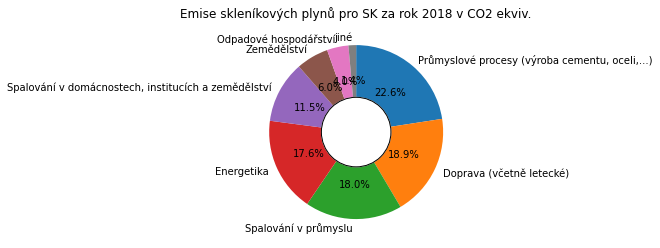

In [461]:
_, ax = plt.subplots() 
plt.title(f'Emise skleníkových plynů pro {STATE} za rok {YEAR} v CO2 ekviv.')

plt.pie(df4.loc[inner_sort_order][YEAR], labels = inner_labels, counterclock=False, startangle=90, autopct='%1.1f%%')
inner_circle_fill = plt.Circle((0, 0), 0.4, color='white') # nastavení vnitřního kruhu
inner_circle_edge = plt.Circle((0, 0), 0.4, color='black', fill=False) # nastavení okraje vnitřního kruhu
ax.add_artist(inner_circle_fill) 
ax.add_artist(inner_circle_edge)
plt.show() 

## Graf 2

In [462]:
df_outer = df3.query("src_crf in ('CRF2C', 'CRF2A', 'CRF2B','CRF1A3B1','CRF1A3B2','CRF1A3B3','CRF1D1A','CRF1A3A','CRF1A1C','CRF1A1B','CRF1A2A','CRF1A2B')") 
df_outer = df_outer.set_index('src_crf') 

Úpravy a dopočty dalších buněk pro graf.

In [463]:
# Uprav df_outer: vytvoř tohle: CRF1A3B2|CRF1A3B3 
D = df_outer.loc['CRF1A3B2', YEAR] + df_outer.loc['CRF1A3B3', YEAR] 
D_df = pd.DataFrame({YEAR:[D]}, index = ['CRF1A3B2_CRF1A3B3']) # vytvoř nový df se sloupcem "YEAR", příslušným indexem a hodnotou vypoč. jako "D"
df_outer = df_outer.append(D_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.drop(index = 'CRF1A3B2') # zahoď původní hodnotu
df_outer = df_outer.drop(index = 'CRF1A3B3')


In [464]:
# Uprav df_outer: vytvoř tohle: CRF1D1A|CRF1A3A
E = df_outer.loc['CRF1D1A', YEAR] + df_outer.loc['CRF1A3A', YEAR] 
E_df = pd.DataFrame({YEAR:[E]}, index = ['CRF1D1A_CRF1A3A']) # vytvoř nový df se sloupcem "YEAR", příslušným indexem a hodnotou vypoč. jako "E"
df_outer = df_outer.append(E_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.drop(index = 'CRF1D1A') # zahoď původní hodnotu
df_outer = df_outer.drop(index = 'CRF1A3A') # zahoď původní hodnotu

In [465]:
# Uprav df_outer: vytvoř tohle: CRF1A2A|CRF1A2B
F = df_outer.loc['CRF1A2A', YEAR] + df_outer.loc['CRF1A2B', YEAR]
F_df = pd.DataFrame({YEAR:[F]}, index = ['CRF1A2A_CRF1A2B']) # vytvoř nový df se sloupcem "YEAR", příslušným indexem a hodnotou vypoč. jako "F"
df_outer = df_outer.append(F_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.drop(index = 'CRF1A2A') # zahoď původní hodnotu
df_outer = df_outer.drop(index = 'CRF1A2B') # zahoď původní hodnotu

In [466]:
# Uprav df_outer: vytvoř tohle: CRF2_rozdil. Tedy: "další prům proc" = CRF2 - (CRF2A + CRF2B + CRF2C)
G = df_outer.loc['CRF2A', YEAR] + df_outer.loc['CRF2B', YEAR] + df_outer.loc['CRF2C', YEAR]
H = df4.loc['CRF2', YEAR] - G
H_df = pd.DataFrame({YEAR:[H]}, index = ['CRF2_rozdil'])
df_outer = df_outer.append(H_df) # přilep nový dataframe ke stávajícímu 

In [467]:
# Uprav df_outer: vytvoř tohle: CRF1A2_rozdil. Tedy: "další spalování v průmyslu" = CRF1A2 - CRF1A2A_CRF1A2B
I = df4.loc['CRF1A2', YEAR] - df_outer.loc['CRF1A2A_CRF1A2B', YEAR]
I_df = pd.DataFrame({YEAR:[I]}, index = ['CRF1A2_rozdil'])
df_outer = df_outer.append(I_df) # přilep nový dataframe ke stávajícímu 

In [468]:
# Uprav df_outer: vytvoř tohle: CRF1A1C_CRF1A1B. Tedy: "rafinace a spol" = CRF1A1C + CRF1A1B
J = df_outer.loc['CRF1A1C', YEAR] + df_outer.loc['CRF1A1B', YEAR]
J_df = pd.DataFrame({YEAR:[J]}, index = ['CRF1A1C_CRF1A1B'])
df_outer = df_outer.append(J_df) # přilep nový dataframe ke stávajícímu 
df_outer = df_outer.drop(index = 'CRF1A1C') # zahoď původní hodnotu
df_outer = df_outer.drop(index = 'CRF1A1B') # zahoď původní hodnotu

In [469]:
# Uprav df_outer: vytvoř tohle: CRF1A3_rozdil. Tedy = CRF1A3_CRF1D1A - (CRF1A3B1 + CRF1A3B2_CRF1A3B3 + CRF1D1A_CRF1A3A)
K = df4.loc['CRF1A3_CRF1D1A', YEAR] - (df_outer.loc['CRF1A3B1', YEAR] + df_outer.loc['CRF1A3B2_CRF1A3B3', YEAR] + df_outer.loc['CRF1D1A_CRF1A3A', YEAR])
K_df = pd.DataFrame({YEAR:[K]}, index = ['CRF1A3_rozdil'])
df_outer = df_outer.append(K_df) # přilep nový dataframe ke stávajícímu 

In [470]:
# Tohle je DÍLČÍ ROZDÍL. Ještě příde dál rozpadnout. 
# Uprav df_outer: vytvoř tohle: CRF1A1_rozdil_X. Tedy CRF1A1_rozdil_X = CRF1A1 - CRF1A1C_CFR1A1B
L = df4.loc['CRF1A1', YEAR] - df_outer.loc['CRF1A1C_CRF1A1B', YEAR]
L_df = pd.DataFrame({YEAR:[L]}, index = ['CRF1A1_rozdil_X'])
df_outer = df_outer.append(L_df) # přilep nový dataframe ke stávajícímu 

In [471]:
# přidat hodnoty z vnitřního grafu
M = df4.loc['CRF1A4', YEAR] # spalování v domácnostech ... 
N = df4.loc['CRF3', YEAR] # zemědělství
O = df4.loc['CRF5', YEAR] # odpadové hospodářství
P = df4.loc['TOTX4_MEMONIA', YEAR] # jiné

M_df = pd.DataFrame({YEAR:[M]}, index = ['CRF1A4'])
df_outer = df_outer.append(M_df) # přilep nový dataframe ke stávajícímu 

N_df = pd.DataFrame({YEAR:[N]}, index = ['CRF3'])
df_outer = df_outer.append(N_df) # přilep nový dataframe ke stávajícímu 

O_df = pd.DataFrame({YEAR:[O]}, index = ['CRF5'])
df_outer = df_outer.append(O_df) # přilep nový dataframe ke stávajícímu 

P_df = pd.DataFrame({YEAR:[P]}, index = ['TOTX4_MEMONIA'])
df_outer = df_outer.append(P_df) # přilep nový dataframe ke stávajícímu 

In [472]:
# vytvoř list popisků iterací přes slovník
outer_labels = [label_dict_2[x] for x in outer_sort_order] 

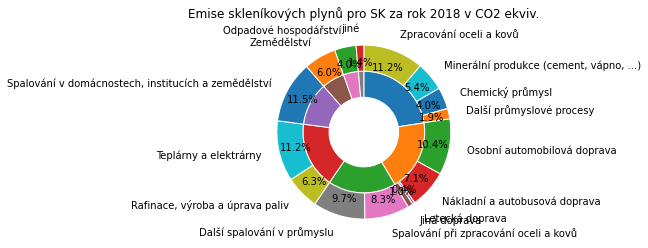

In [473]:
fig, ax = plt.subplots()

size = 0.3

# vnitřní
ax.pie(df4.loc[inner_sort_order][YEAR], radius=1-size, counterclock=False, startangle=90, 
       wedgeprops=dict(width=size, edgecolor='w'))

# vnější
ax.pie(df_outer.loc[outer_sort_order][YEAR], # tohle mi to řadí a 'YEAR' bere hodnoty ze sloupce YEAR
       radius=1, labels = outer_labels, counterclock=False, startangle=90, 
       autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.2, wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title = f'Emise skleníkových plynů pro {STATE} za rok {YEAR} v CO2 ekviv.')
plt.show()

# CRF1A1_rozdil_X bude ještě nutno dál rozpadnout: elektrárny - povolenky, teplárny... a to nebude úplně lehký

Ptej se na:
- barvy grafu
- změny velikosti popisků a procent v grafu

## Další provozní kusy kodu

Graf 2: Na pevno - ať vidim ja to má vypadat

In [474]:
d = {'col1': ['CRF2C', 'CRF2A', 'CRF2B', 'dalsi', 'zbytek'], 'col2': [4.75, 2.28, 1.7, 0.88, 32.7] } # zatim napevno
df_outer_demo = pd.DataFrame(data=d)

In [475]:
df_outer_demo = df_outer_demo.set_index('col1')

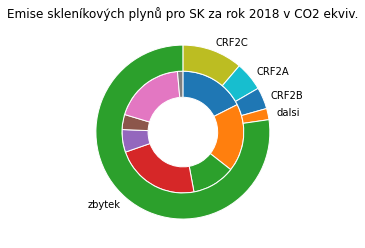

In [476]:
fig, ax = plt.subplots()

size = 0.3

# vnitřní
ax.pie(df4[YEAR], radius=1-size, counterclock=False, startangle=90, 
       wedgeprops=dict(width=size, edgecolor='w'))

# vnější
ax.pie(df_outer_demo['col2'], radius=1, labels = df_outer_demo.index, counterclock=False, startangle=90, 
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title=f'Emise skleníkových plynů pro {STATE} za rok {YEAR} v CO2 ekviv.')
plt.show()

Další kousky

In [477]:
total = df4[YEAR].sum() # sečti sloupec
total

42.32090999999999

In [478]:
print (df4[YEAR].dtypes) # zjisti datový typ sloupce

float64


In [479]:
list(df3.columns) # vyjeď názvy sloupců

['src_crf', 2018]

In [480]:
df.airpol.unique() # ukáže mi co unikátního tam všechno mám 

array(['CH4', 'CH4_CO2E', 'CO2', 'GHG', 'HFC_CO2E', 'HFC_PFC_NSP_CO2E',
       'N2O', 'N2O_CO2E', 'NF3_CO2E', 'PFC_CO2E', 'SF6_CO2E'],
      dtype=object)